In [11]:
import pandas as pd
from pyodide.http import open_url
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

print("Fetching dataset using Pyodide's fetch API...")

train_url = "https://raw.githubusercontent.com/WissemBellara/Network-intrusion-detection-kaggle-dataset-supervised-unsupervised-reinforcement-learning-/main/Train_data.csv"
test_url = "https://raw.githubusercontent.com/WissemBellara/Network-intrusion-detection-kaggle-dataset-supervised-unsupervised-reinforcement-learning-/main/Test_data.csv"

# Load into pandas
train_df = pd.read_csv(open_url(train_url))
kaggle_test_df = pd.read_csv(open_url(test_url))

print(f"Success! Train shape: {train_df.shape}, Kaggle Test shape: {kaggle_test_df.shape}")

# 1. Separate features (X) and target label (y) from the TRAIN data
X = train_df.drop('class', axis=1)
y = train_df['class']

# 2. Preprocess categorical features
X_encoded = pd.get_dummies(X)
kaggle_test_encoded = pd.get_dummies(kaggle_test_df)

# Align columns to ensure the test set matches the training features exactly
X_encoded, kaggle_test_encoded = X_encoded.align(kaggle_test_encoded, join='left', axis=1, fill_value=0)

# 3. Create a Validation Set from the training data so we can evaluate accuracy
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 4. Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
kaggle_test_scaled = scaler.transform(kaggle_test_encoded)

# 5. Train the Model
print("Training model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 6. Evaluate on our Validation Set
print("Evaluating model on validation set...")
val_predictions = model.predict(X_val_scaled)
print("\n--- Classification Report ---")
print(classification_report(y_val, val_predictions))

# 7. Predict the actual Kaggle Test Set (which has no labels)
print("\nGenerating final predictions for Test_data.csv...")
final_predictions = model.predict(kaggle_test_scaled)
print(f"First 10 predictions: {final_predictions[:10]}")

Fetching dataset using Pyodide's fetch API...
Success! Train shape: (25192, 42), Kaggle Test shape: (22544, 41)
Training model...
Evaluating model on validation set...

--- Classification Report ---
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      2365
      normal       1.00      1.00      1.00      2674

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039


Generating final predictions for Test_data.csv...
First 10 predictions: ['anomaly' 'anomaly' 'normal' 'anomaly' 'normal' 'normal' 'normal'
 'normal' 'normal' 'normal']


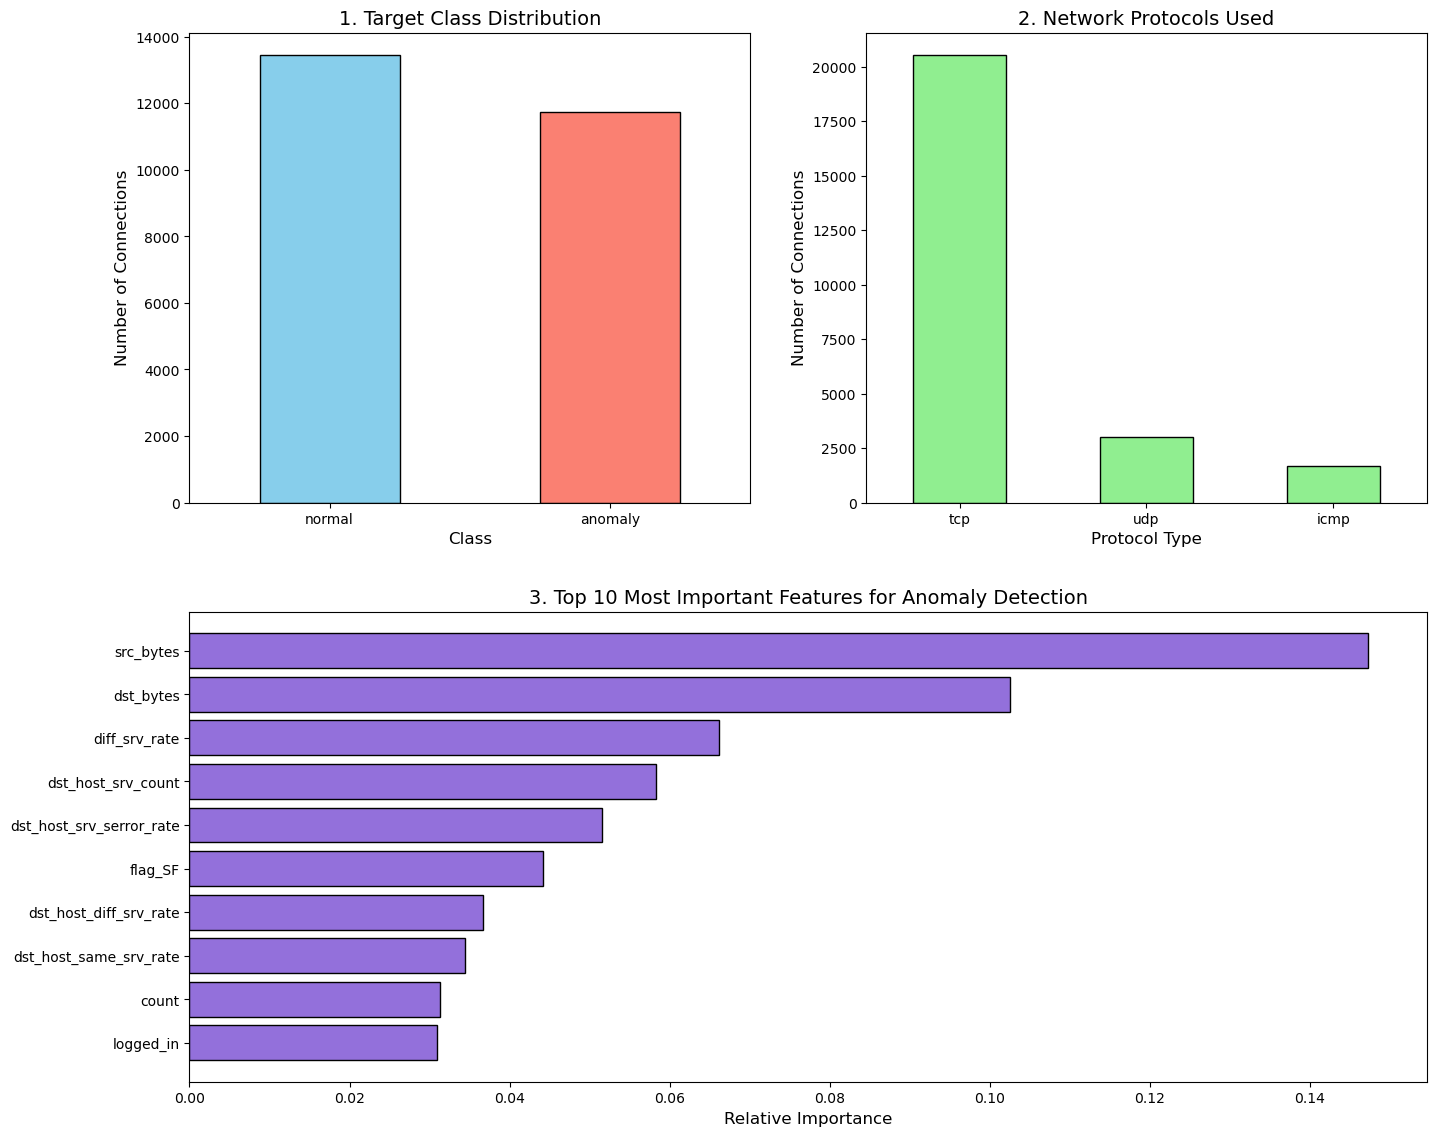

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Set up a larger figure for multiple plots
fig = plt.figure(figsize=(15, 12))

# ==========================================
# Visualization 1: Class Distribution
# ==========================================
# Shows the balance between 'normal' and 'anomaly' connections
plt.subplot(2, 2, 1)
class_counts = train_df['class'].value_counts()
class_counts.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title('1. Target Class Distribution', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Connections', fontsize=12)
plt.xticks(rotation=0)

# ==========================================
# Visualization 2: Protocol Types
# ==========================================
# Shows the dominant network protocols in the dataset
plt.subplot(2, 2, 2)
protocol_counts = train_df['protocol_type'].value_counts()
protocol_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('2. Network Protocols Used', fontsize=14)
plt.xlabel('Protocol Type', fontsize=12)
plt.ylabel('Number of Connections', fontsize=12)
plt.xticks(rotation=0)

# ==========================================
# Visualization 3: Top 10 Feature Importances
# ==========================================
# Shows exactly WHICH columns the Random Forest relied on most to detect anomalies
plt.subplot(2, 1, 2)

# Extract importances from your already-trained model
importances = model.feature_importances_
feature_names = X_train.columns

# Bundle them into a dataframe and sort
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_10 = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

# Plot as a horizontal bar chart
plt.barh(top_10['Feature'], top_10['Importance'], color='mediumpurple', edgecolor='black')
plt.title('3. Top 10 Most Important Features for Anomaly Detection', fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.gca().invert_yaxis()  # Puts the highest importance at the top

# Adjust layout and display
plt.tight_layout(pad=3.0)
plt.show()